### Reference  : 
1. https://arxiv.org/pdf/1512.03385.pdf
2. https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/CNN_architectures/pytorch_resnet.py
3. https://www.youtube.com/watch?v=DkNIBBBvcPs&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=21
4. https://medium.com/analytics-vidhya/assemble-resnet-that-is-5-times-faster-with-the-same-accuracy-as-efficientnet-b6-autoaugment-c752f1835c38
5. https://arxiv.org/pdf/2001.06268.pdf

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *

In [2]:
%tensorflow_version 2.x
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.620068964999973
GPU (s):
0.03320540300001085
GPU speedup over CPU: 78x


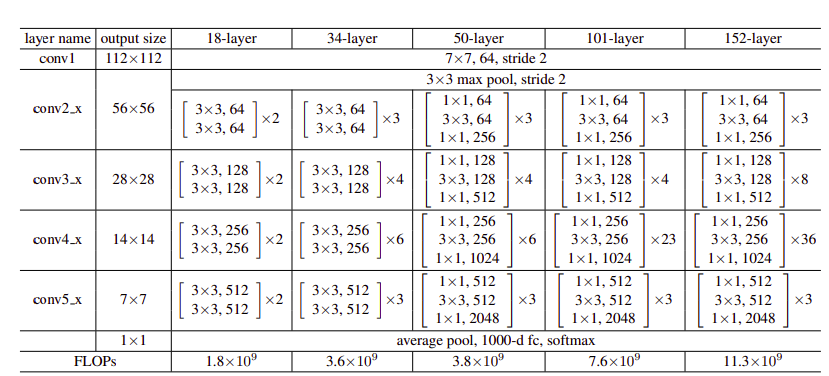

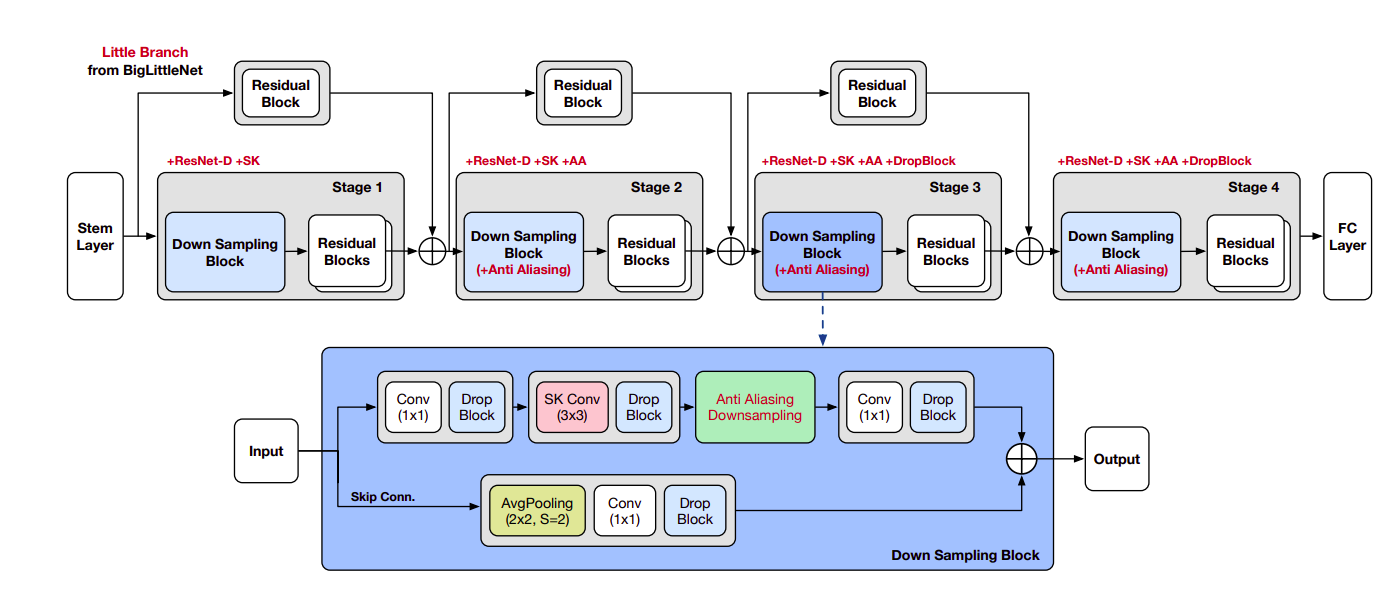

In [10]:
versions = {
    '50' : [3, 4, 6, 3],
    '101' : [3, 4, 23, 3],
    '152' : [3, 8, 36, 3]
}

In [11]:
class resBlock(tf.keras.layers.Layer):
  def __init__(self, channels ,  stride = 1 , downsample = None) : 
    super(resBlock , self).__init__()

    self.conv1 = Conv2D(channels , (1,1) , strides = (stride, stride) , padding = 'same')
    self.bn1 = BatchNormalization()
    self.conv2 = Conv2D(channels , (3,3) , strides = (stride, stride) , padding = 'same')
    self.bn2 = BatchNormalization()
    self.conv3 = Conv2D(channels*4 , (1,1) , strides = (1, 1) , padding = 'same')
    self.bn3 = BatchNormalization()
    self.relu = Activation('relu')
    self.downsample = downsample

  def call(self, x):
    y = self.conv1(x)
    y = self.bn1(y)
    y = self.conv2(y)
    y = self.bn2(y)
    y = self.conv3(y)
    y = self.bn3(y)

    if self.downsample != None : 
      for l in self.downsample : 
        x = l(x)
    x = x + y
    x = self.relu(x)
    return x   

class selectiveKernel(tf.keras.layers.Layer):
  def __init__(self , channels):
    super(selectiveKernel , self).__init__()

    ## selective kernel 
    self.channels = channels
    self.conv = Conv2D(2*channels , (3,3) , strides = (1, 1) , padding = 'same')
    self.bn = BatchNormalization()
    self.avgPool = GlobalAveragePooling2D()
    self.d1 = Dense(channels , activation = 'softmax')
    self.d2 = Dense(channels , activation = 'softmax')

  def get_config(self):
    return {"channels": self.channels}

  def call(self,x):
    x = self.conv(x)
    x = self.bn(x)
    x1 = x[:,:,:,:self.channels]
    x2 = x[:,:,:,self.channels:]
    y = x1 + x2
    y = self.avgPool(y)
    y1 = self.d1(y)
    y2 = self.d2(y)
    x1 = Multiply()([y1 , x1])
    x2 = Multiply()([y2 , x2])
    return x1 + x2


class antiAlias(tf.keras.layers.Layer):
  # TODO : implement antialias layer
  def __init__(self, stride = 2):
    super(antiAlias , self).__init__()
    self.mp = MaxPool2D(pool_size=(2,2) ,strides = (stride,stride) ,padding = 'same')

  # def get_config(self):
  #     return {"hidden_units": self.hidden_units}

  def call(self , x):
    return self.mp(x)

# class dropBlock(tf.keras.layers.Layer):
#   def __init__(self):
#     super(dropBlock , self).__init__()
  
#   def call(self , x):
#     return x

class resDownsampleBlock(tf.keras.layers.Layer):
  def __init__(self, channels ,  stride = 1 , downsample = None) : 
    super(resDownsampleBlock , self).__init__()

    self.conv1 = Conv2D(channels , (1,1) , strides = (1, 1) , padding = 'same')
    self.bn1 = BatchNormalization()

    ## selective kernel 
    self.SK = selectiveKernel(channels)
    self.bn2 = BatchNormalization()

    self.stride = stride
    self.antiAlias = antiAlias(stride = stride)
    
    self.conv3 = Conv2D(channels*4 , (1,1) , strides = (1, 1) , padding = 'same')
    self.bn3 = BatchNormalization()
    self.relu = Activation('relu')
    self.downsample = downsample

    # self.dropBlock = dropBlock()

  def call(self, x):
    y = self.conv1(x)
    y = self.bn1(y)
    # y = self.dropBlock(y)
    y = self.SK(y)
    y = self.bn2(y)
    # y = self.dropBlock(y)
    if self.stride > 1:y = self.antiAlias(y)
    y = self.conv3(y)
    y = self.bn3(y)
    # y = self.dropBlock(y)
    if self.downsample != None : 
      for l in self.downsample : 
        x = l(x)
    x = x + y
    x = self.relu(x)
    return x   


In [12]:
class Assemble_Resnet(tf.keras.Model):
  def __init__(self , version = '50' , num_classes = '10' , image_channels = '3'):
    super(Assemble_Resnet , self).__init__()
    self.conv1 = Conv2D(64 , (3,3), strides=(2,2) , padding='same')
    self.bn1 =  BatchNormalization()

    self.conv2 = Conv2D(64 , (3,3), strides=(1,1) , padding='same')
    self.bn2 =  BatchNormalization()
    
    self.conv3 = Conv2D(64 , (3,3), strides=(1,1) , padding='same')
    self.bn3 =  BatchNormalization()
    self.relu = Activation('relu')

    self.maxpool = MaxPool2D(pool_size= (3,3) , strides=(2,2), padding = 'same')
    repeat_counts = versions[version]
    self.b1 = self.generate_block( 64 ,  repeat_counts[0] , stride = 1)
    self.b2 = self.generate_block( 128 ,  repeat_counts[1] , stride = 2)
    self.b3 = self.generate_block( 256 ,  repeat_counts[2] , stride = 2)
    self.b4 = self.generate_block( 512 ,  repeat_counts[3] , stride = 2)
    self.avgpool = GlobalAveragePooling2D()
    self.fc = Dense(num_classes , activation = 'softmax')

  def generate_block(self, channels , repeat_count , stride):
    identity_downsamples = None
    layers = []
    # if stride != 1 or channels == 64 : 
    identity_downsamples = [AveragePooling2D(pool_size=(2,2) , strides = (stride,stride) , padding = 'same') ,    Conv2D(channels*4 , (1,1) , strides = (1,1) , padding = 'same') , BatchNormalization()]
    
    layers.append(resDownsampleBlock(channels , stride = stride , downsample = identity_downsamples))

    for i in range(repeat_count - 1):
      layers.append(resBlock(channels , stride = 1 , downsample = None))
    return layers

  def call(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.conv3(x)
    x = self.bn3(x)

    x = self.relu(x)
    x = self.maxpool(x)
    for l in self.b1: x = l(x)
    for l in self.b2: x = l(x)
    for l in self.b3: x = l(x)
    for l in self.b4: x = l(x)
    x = self.avgpool(x)
    x = self.fc(x)
    return x

  def summary1(self):
    x = Input(shape=(224,224,3))
    model_struct =  tf.keras.models.Model(inputs = x , outputs = self.call(x))
    print(model_struct.summary())


In [13]:
model = Assemble_Resnet(version='50')
model.summary1()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 112, 112, 64)      1792      
_________________________________________________________________
batch_normalization_11 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_12 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 112, 112, 64)      256   

In [14]:
x = tf.random.uniform(shape = (400 , 224 ,224 ,3)  ,maxval = 1)
y = tf.random.uniform(shape = (400,  10) , maxval = 1)


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
model.fit(x, y, epochs=10, batch_size=16)

model.save_weights('tmp.hdf5')
model.save('tmp/')

Epoch 1/10
25/25 [==============================] - 16s 237ms/step - loss: 0.2556
Epoch 2/10
25/25 [==============================] - 6s 237ms/step - loss: 0.2262
Epoch 3/10
25/25 [==============================] - 6s 238ms/step - loss: 0.2180
Epoch 4/10
25/25 [==============================] - 6s 241ms/step - loss: 0.2172
Epoch 5/10
25/25 [==============================] - 6s 241ms/step - loss: 0.2169
Epoch 6/10
25/25 [==============================] - 6s 243ms/step - loss: 0.2158
Epoch 7/10
25/25 [==============================] - 6s 244ms/step - loss: 0.2135
Epoch 8/10
25/25 [==============================] - 6s 246ms/step - loss: 0.2133
Epoch 9/10
25/25 [==============================] - 6s 247ms/step - loss: 0.2128
Epoch 10/10
25/25 [==============================] - 6s 249ms/step - loss: 0.2123


INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets
